<a href="https://colab.research.google.com/github/abhishinde24/Short-term-Forecasting-of-Load-and-Solar-Energy-in-a-Smart-Grid/blob/main/SArima_for_load_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [ ]:
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [ ]:
def walk_forward_validation(data, n_test, cfg):
 predictions = list()
 # split dataset
 train, test = train_test_split(data, n_test)
	# seed history with training dataset
 history = [x for x in train]
	# step over each time-step in the test set
 for i in range(len(test)):
		# fit model and make forecast for history
	 yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
	 predictions.append(yhat)
		# add actual observation to history for the next loop
	 history.append(test[i])
	# estimate prediction error
 return predictions

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
# calculating precentage error
def cal_error(y,x):
    return mean_absolute_percentage_error(y,x)

In [ ]:
df = pd.read_csv('/content/sample_data/EKPC_hourly.csv',header=0,infer_datetime_format=True,parse_dates=['Datetime'],index_col=['Datetime'])


In [ ]:
df.head()
daily_groups = df.resample('D')
df = daily_groups.sum()

In [ ]:
df=df[:][:-10]

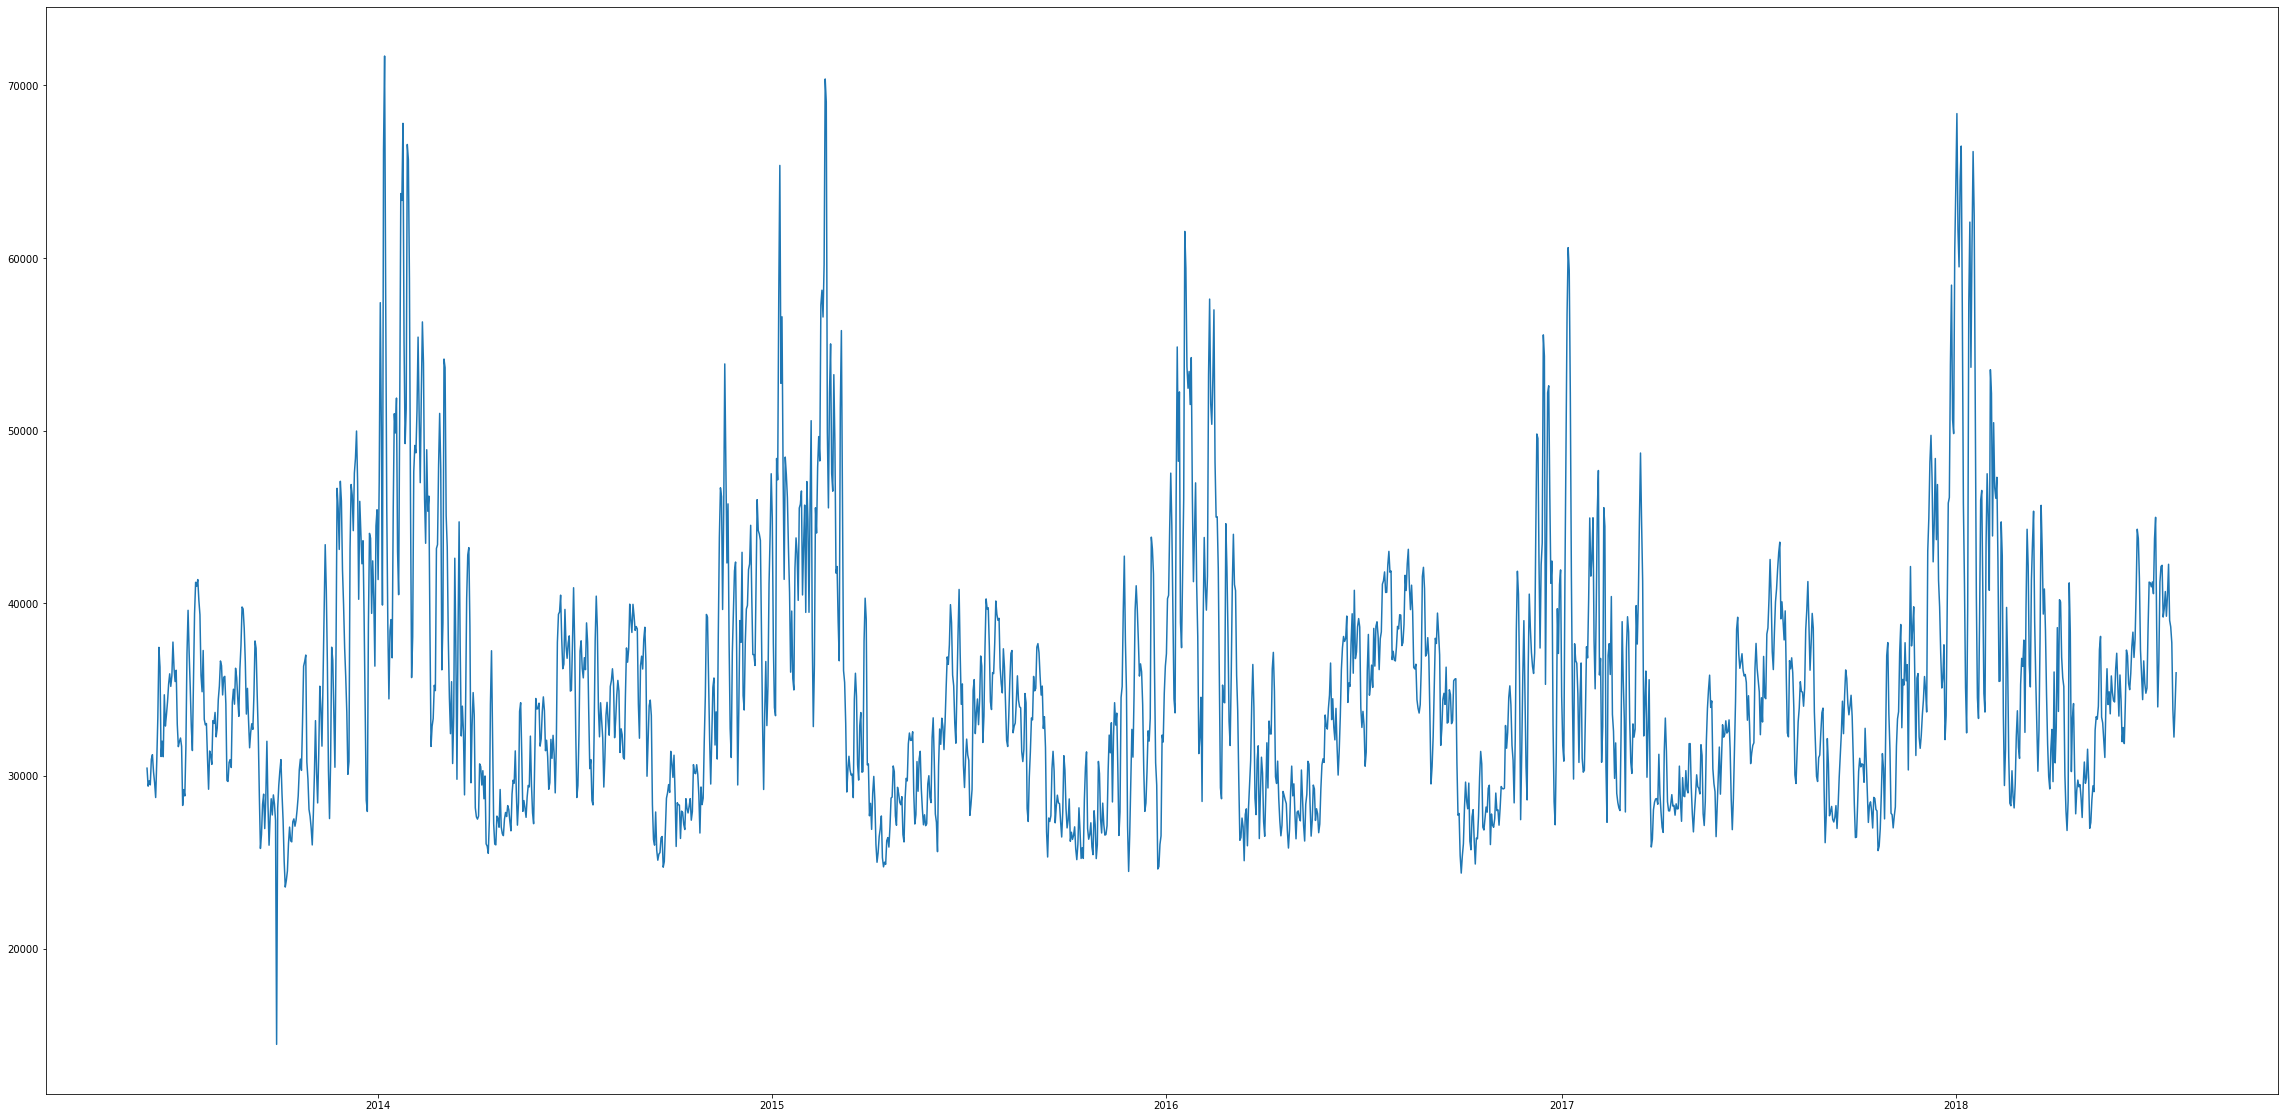

In [ ]:
plt.figure(figsize=(40,20))
plt.plot(df['EKPC_MW'])

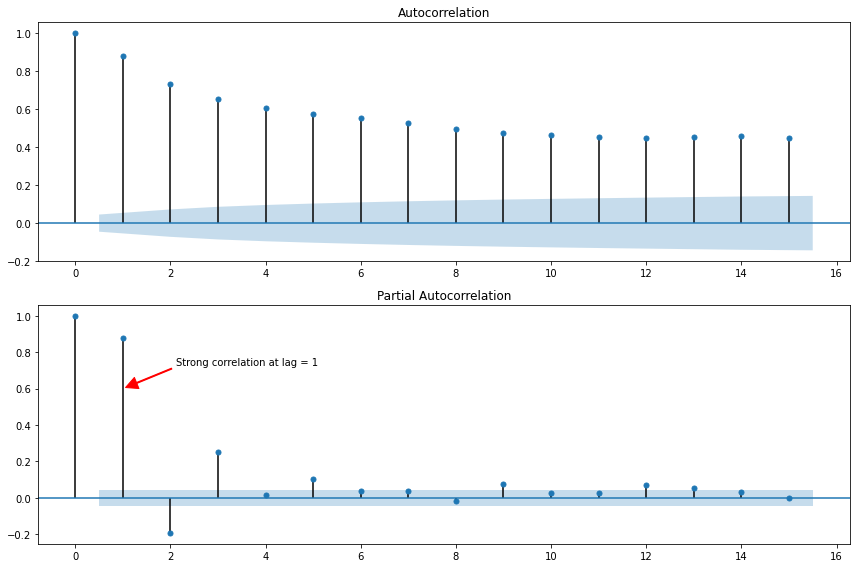

In [ ]:
#ploting acf and pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
lag_acf = 15
lag_pacf = 15
height = 4
width = 12
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(df['EKPC_MW'],lags=lag_acf, ax=ax[0])
plot_pacf(df['EKPC_MW'],lags=lag_pacf, ax=ax[1], method='ols')
ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()

In [ ]:
# def seasonal_plot(df, season='year', index='month', column=None):
#     """Makes a seasonal plot of one column of the input dataframe. Considers the first columns by default.
    
#     Arguments:
    
#     - df (Pandas DataFrame): DataFrame indexed by Datetime (see `parse_dates` parameter when reading a CSV);
#     - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
#     - index (string): corresponds to the X axis of the plot. You should choose based on the index period that you're using;
#     - column (string, optional): the DataFrame column to consider. Picks the first one by default.
#     """
#     if column == None:
#         column = df.columns[0]
        
#     piv_index = getattr(df.index, index)
#     piv_season = getattr(df.index, season)
    
#     piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
#     piv.plot(figsize=(12,8))

In [ ]:

# from statsmodels.tsa.seasonal import seasonal_decompose

# data_orig.set_index('Date', inplace=True)
# seasonal_plot(df)
# analysis = df['EKPC_MW'].copy()


# decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

# trend = decompose_result_mult.trend
# seasonal = decompose_result_mult.seasonal
# residual = decompose_result_mult.resid

# decompose_result_mult.plot();

In [ ]:
df.head()

,EKPC_MW
Datetime,
2013-06-01,30445
2013-06-02,29403
2013-06-03,29710
2013-06-04,29478
2013-06-05,30962


In [ ]:
start_date = '2017-01-01'
end_date = '2017-12-31'

In [ ]:
mask = (df.index >= start_date) & (df.index <= end_date)
df = df.loc[mask]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

4561.379547682074


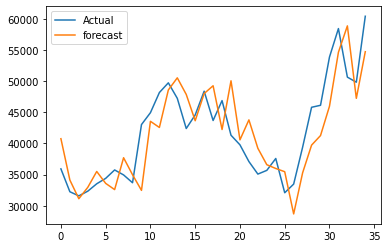

In [ ]:
data=df['EKPC_MW'].to_list()
#converting into MWH
data=data
# data split
n_test = 35
# next days prediction

# cfg_list = [(0,0,2),(1,0,2,0),'n']
cfg_list = [(3,1,1),(2,1,0,4),'t']
# cfg_list = [(1,0,0),(2,0,1,0),'ct']

prediction=walk_forward_validation(data,n_test,cfg_list)
print(measure_rmse(data[-n_test:],prediction))
plt.plot(data[-n_test:])
plt.plot(prediction)
plt.gca().legend(('Actual','forecast'))
plt.show()

In [ ]:
# output=pd.DataFrame(prediction)
# output.to_csv('output.csv')
print("percentage error is : ",cal_error(data[-n_test:],prediction)*100)

percentage error is :  8.828869794917367


In [ ]:
output=pd.DataFrame([df.index[-35:] , data[-n_test:], prediction])

In [ ]:
output.to_csv('final_sarima.csv')